# Анализ продаж e-commerce

### Цель анализа
Провести исследование данных по продажам и подготовить отчет с информацией для Product Manager.

### Задачи
1. Определить количество пользователей совершивших покупку только один раз.
2. Определить среднемесячное количество заказов, которые не доставляются по разным причинам.
3. По каждому товару определить, в какой день недели товар чаще всего покупается.
4. Определить среднее количество покупок у каждого пользователя в неделю с детализацией по месяцам.
5. Провести когортный анализ пользователей и определить когорту с самым высоким retention на 3-й месяц в период с января по декабрь.
6. Построить RFM-сегментацию пользователей, для качественной оценки аудиторию.

### Данные для анализа

-  **[olist_customers_dataset.csv](https://disk.yandex.ru/d/QXrVDUoQvFhIcg) — таблица с уникальными идентификаторами пользователей**
    - `customer_id` — позаказный идентификатор пользователя
    - `customer_unique_id` —  уникальный идентификатор пользователя  (аналог номера паспорта)
    - `customer_zip_code_prefix` - почтовый индекс пользователя
    - `customer_city` —  город доставки пользователя
    - `customer_state` —  штат доставки пользователя
    

- **[olist_orders_dataset.csv](https://disk.yandex.ru/d/0zWmh1bYP6REbw) — таблица заказов**
    - `order_id` — уникальный идентификатор заказа (номер чека)
    - `customer_id` — позаказный идентификатор пользователя
    - `order_status` — статус заказа
        - `created` — создан
        - `approved` — подтверждён
        - `invoiced` — выставлен счёт
        - `processing` — в процессе сборки заказа
        - `shipped` — отгружен со склада
        - `delivered` — доставлен пользователю
        - `unavailable` — недоступен
        - `canceled` — отменён
    - `order_purchase_timestamp` — время создания заказа
    - `order_approved_at` — время подтверждения оплаты заказа
    - `order_delivered_carrier_date` — время передачи заказа в логистическую службу
    - `order_delivered_customer_date` — время доставки заказа
    - `order_estimated_delivery_date` — обещанная дата доставки
    

- **[olist_order_items_dataset.csv](https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg) — товарные позиции, входящие в заказы**
    - `order_id` — уникальный идентификатор заказа (номер чека)
    - `order_item_id` — идентификатор товара внутри одного заказа
    - `product_id` — ид товара (аналог штрихкода)
    - `seller_id` — ид производителя товара
    - `shipping_limit_date` — максимальная дата доставки продавцом для передачи заказа партнеру по логистике
    - `price` — цена за единицу товара
    - `freight_value` — вес товара


### Загрузка и первичный осмотр данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from operator import attrgetter
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from urllib.parse import urlencode

In [2]:
def url_ydisk (url):
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = url

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    return download_url

In [3]:
# Чтение данных из файлов
customers = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/QXrVDUoQvFhIcg'))
orders = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/0zWmh1bYP6REbw'), 
                     parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                                  'order_delivered_customer_date', 'order_estimated_delivery_date'])
order_items = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'))

In [4]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [6]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
# Проверка типов данных в таблице с датами
orders.dtypes 

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [8]:
# Проверка статусов заказов
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [9]:
# Проверка значений NaN
customers.isna().sum() 

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [10]:
# Проверка значений NaN
orders.isna().sum() 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [11]:
# Проверка значений NaN
order_items.isna().sum() 

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [12]:
# Проверка на дубликаты
customers.duplicated().sum()

0

In [13]:
# Проверка на дубликаты
orders.duplicated().sum()

0

In [14]:
# Проверка на дубликаты
order_items.duplicated().sum()

0

In [15]:
order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


Проверили все датафреймы на количество строк, форматы загруженных данных, отсутствие пустых значений, где это противоречит бизнес-логике.

### 1. Сколько у нас пользователей, которые совершили покупку только один раз? 

Чтобы определить, что считать покупкой, важно учесть статус заказа. 

Подходов к оценке может быть много и обычно они зависят от политики компании. Поскольку у нас нет дополнительной инфорамции, я считаю полноценными покупками только заказы со статусом `delivered`, так как товар был успешно доставлен клиенту. 

In [16]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [17]:
# Выведем количество заказов с пропущенными значениями в столбцах логирования времени
orders[orders.order_status == "delivered"].query('order_delivered_customer_date != order_delivered_customer_date | order_delivered_carrier_date != order_delivered_carrier_date | order_approved_at != order_approved_at').count()

order_id                         23
customer_id                      23
order_status                     23
order_purchase_timestamp         23
order_approved_at                 9
order_delivered_carrier_date     21
order_delivered_customer_date    15
order_estimated_delivery_date    23
dtype: int64

Получаем:
- отменять заказы клиенты могут на любом статусе.
- `unavailable` добавляется только в процессе `processing`.
- в описании колонка `order_approved_at` должна содержать время подтверждения оплаты, но из предыдущих рассуждений получаем, что время пишется в колонку не только после получения оплаты, тут может быть некорректное описание или ошибка при логировании.
- в статусе `delivered` наблюдаются скачки количества заказов в колонках логирования времени, обнаружили ошибки в 23 случаях. 

Таким образом, будем использовать статус `delivered`. В этих статусах клиенты могут отменять заказы, но вероятность этого слижком мала, так что можем этим принебречь.

In [18]:
# Объединение таблиц customers и orders по customer_id
merged_df = customers.merge(orders, on='customer_id')

In [19]:
# Данные с доставленными заказами
delivered_orders = merged_df.query('order_status == "delivered"')
delivered_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [20]:
# Количество заказов для каждого пользователя
num_orders = delivered_orders.groupby('customer_unique_id') \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'num_orders'}) \
    .query('num_orders == 1')

#### Результат

In [21]:
print(f'Количество пользователей, которые совершили покупку только один раз: {num_orders.shape[0]}')

Количество пользователей, которые совершили покупку только один раз: 90557


### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

Исходя из имеющихся данных можем выделить следующие причины отказов:
- Отказ от заказа - статус отменен, залогирован после осуществления заказа, на следующие этапы не переходил
- Отказ после подтверждения/оплаты - статус отменен, залогирован после подтверждения/оплаты, на следующие этапы не переходил
- Отказ после передачи в службу доставки - статус отменен, залогирован после передачи в доствку, на следующие этапы не переходил
- Отказ после доставки - статус отменен, залогирован после получения заказа клиентом
- Недоступность товара - статус недоступен, залогирован после передачи на комплектацию

In [22]:
# Фильтрация заказов, которые не были доставлены
# Во избежание предупреждения SettingWithCopyWarning создадим копию
not_delivered_orders = orders.query('order_status in ["canceled", "unavailable"]').copy()

In [23]:
# Добавление нового столбца - извлечение месяца
not_delivered_orders['month'] = not_delivered_orders['order_purchase_timestamp'].dt.strftime('%Y-%m')

In [24]:
# Количество недоставленных заказов в каждый из месяцев 
num_orders_per_month = not_delivered_orders.groupby(['month', 'order_status']) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'num_orders'}) \
    .unstack(fill_value=0)  # Заполним пропущенные значения в результате группировки и агрегации

num_orders_per_month.head()

num_orders            
order_status   canceled unavailable
month                              
2016-09               2           0
2016-10              24           7
2017-01               3          10
2017-02              17          45
2017-03              33          32

In [25]:
# Округленное среднее число недоставленных заказов в месяц по разным причинам
num_orders_per_month_mean = num_orders_per_month.mean().round()
num_orders_per_month_mean.head()

            order_status
num_orders  canceled        26.0
            unavailable     25.0
dtype: float64

#### Результат

In [26]:
print(f'Количество заказов в месяц в среднем не доставляется по причине "canceled": {num_orders_per_month_mean.loc[("num_orders", "canceled")]}')
print(f'Количество заказов в месяц в среднем не доставляется по причине "unavailable": {num_orders_per_month_mean.loc[("num_orders", "unavailable")]}')

Количество заказов в месяц в среднем не доставляется по причине "canceled": 26.0
Количество заказов в месяц в среднем не доставляется по причине "unavailable": 25.0


In [27]:
# Построим график для визуализации распределения отменных заказов по месяцам с разбивкой по причинам
num_orders_per_month = num_orders_per_month.stack().reset_index()

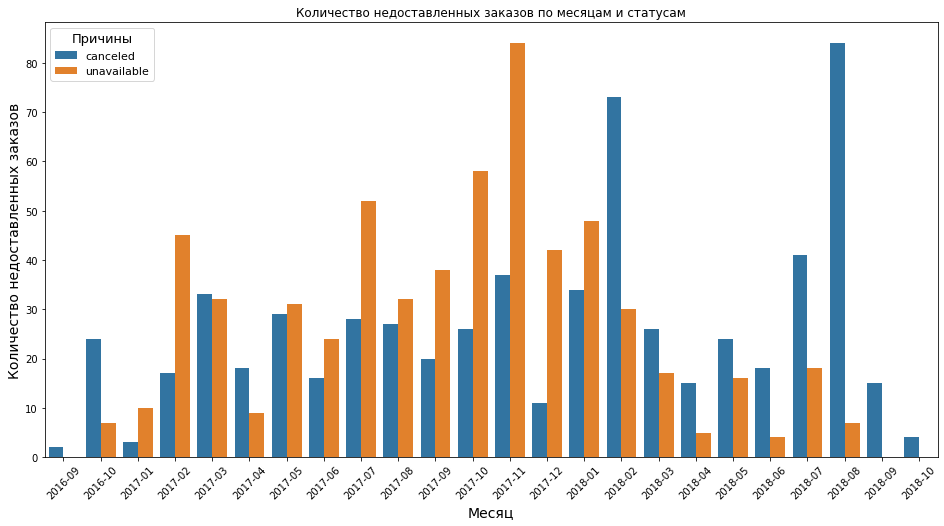

In [28]:
plt.figure(figsize=(16, 8))
sns.barplot(x='month', y='num_orders', hue='order_status', data=num_orders_per_month)
plt.title('Количество недоставленных заказов по месяцам и статусам')
plt.legend(title='Причины', title_fontsize='13', fontsize='11')
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Количество недоставленных заказов', fontsize=14)
plt.xticks(rotation=45)
plt.show()

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.



In [29]:
# Объединение таблиц orders и order_items по order_id
full_orders = orders.merge(order_items, on = 'order_id') 
full_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [30]:
# Добавление нового столбца - извлечение дня недели
full_orders['weekday'] = full_orders['order_purchase_timestamp'].dt.strftime('%A')

In [31]:
# Группировка данных и подсчет количества покупок для каждого товара по дням недели
grouped_orders = full_orders.groupby(['product_id', 'weekday']) \
    .agg({'order_purchase_timestamp':'count'}) \
    .rename(columns={'order_purchase_timestamp':'num_orders'}) 
grouped_orders.head()

num_orders
product_id                       weekday              
00066f42aeeb9f3007548bb9d3f33c38 Sunday              1
00088930e925c41fd95ebfe695fd2655 Tuesday             1
0009406fd7479715e4bef61dd91f2462 Thursday            1
000b8f95fcb9e0096488278317764d19 Friday              1
                                 Wednesday           1

#### Определение дня недели с максимальным количеством покупок для каждого товара:


In [32]:
max_orders_per_product = grouped_orders.loc[grouped_orders.groupby('product_id')['num_orders'].idxmax()]
max_orders_per_product.head()

,,num_orders
product_id,weekday,
00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
00088930e925c41fd95ebfe695fd2655,Tuesday,1
0009406fd7479715e4bef61dd91f2462,Thursday,1
000b8f95fcb9e0096488278317764d19,Friday,1
000d9be29b5207b54e86aa1b1ac54872,Tuesday,1


In [33]:
# Сортировка по количеству покупок в убывающем порядке для каждого товара
sorted_max_orders_per_product = max_orders_per_product.sort_values('num_orders', ascending=False)
sorted_max_orders_per_product.head()

,,num_orders
product_id,weekday,
422879e10f46682990de24d770e7f83d,Wednesday,93
99a4788cb24856965c36a24e339b6058,Monday,92
aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
368c6c730842d78016ad823897a372db,Friday,67


In [34]:
# Соберем общие продажи по каждому дню
sales_weekdays = full_orders \
    .groupby(['weekday'], as_index=False) \
    .agg({'order_item_id': 'count'}) \
    .rename(columns={'order_item_id': 'order_count'})

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

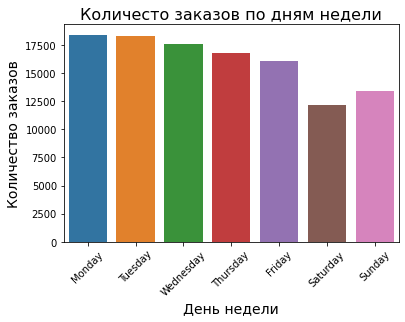

In [35]:
# Построим график заказов по дням
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(data=sales_weekdays, x='weekday', y='order_count', order=day_order)

plt.xlabel('День недели', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.title('Количесто заказов по дням недели', fontsize=16)

plt.xticks(rotation=45)

Дополнительно добавила график общего распределения заказов по дням, благодаря которому мы можем наблюдать резкое снижение количества заказов в выходные дни, особенно в субботу.

### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [36]:
# Объединение таблиц customers и orders по customer_id
cust_orders = customers.merge(orders, on='customer_id')

In [37]:
# Добавление нового столбца - извлечение месяца
cust_orders['month'] = cust_orders['order_purchase_timestamp'].dt.to_period('M')

In [69]:
# Группировка данных и подсчет количества покупок для каждого пользователя по месяцам
grouped_cust_orders = cust_orders.groupby(['customer_unique_id', 'month']) \
    .agg({'order_purchase_timestamp':'count'}) \
    .rename(columns={'order_purchase_timestamp':'num_orders'}) \
    .reset_index()
grouped_cust_orders.head()

,customer_unique_id,month,num_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1


In [70]:
# Добавление нового столбца - количество недель в каждом месяце 
grouped_cust_orders['weeks_per_month'] = grouped_cust_orders['month'].dt.days_in_month / 7
grouped_cust_orders.head()

,customer_unique_id,month,num_orders,weeks_per_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.428571
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.428571
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.285714


In [71]:
grouped_cust_orders['avg_orders_per_week'] = grouped_cust_orders['num_orders'] / grouped_cust_orders['weeks_per_month']
grouped_cust_orders[['customer_unique_id', 'month', 'avg_orders_per_week']].head()

,customer_unique_id,month,avg_orders_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.233333


### Выполните когортный анализ пользователей.

In [41]:
# Определение первой покупки для каждого пользователя
initial_purchase = pd.merge(customers, orders, on='customer_id') \
    .query('order_status == "delivered"') \
    [['customer_unique_id', 'order_approved_at']]
initial_purchase = initial_purchase.groupby('customer_unique_id').agg({'order_approved_at': 'min'}).reset_index()
initial_purchase = initial_purchase.rename(columns={'order_approved_at': 'first_purchase_date'})
initial_purchase.head()

,customer_unique_id,first_purchase_date
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52


In [42]:
# Создание основной таблицы для когортного анализа
cohort_data = pd.merge(customers, orders, on='customer_id')
cohort_data = cohort_data.dropna(subset=['order_approved_at'])
cohort_data['order_approved_at'] = pd.to_datetime(cohort_data['order_approved_at'])
cohort_data['cohort_start'] = cohort_data.groupby('customer_unique_id')['order_approved_at'].transform('min')
cohort_data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cohort_start
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-20 16:19:10
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13 17:29:19
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29 10:10:09


In [43]:
# Извлечение месяца из даты
cohort_data['purchase_month'] = cohort_data['order_purchase_timestamp'].dt.strftime('%Y-%m')
cohort_data['approval_month'] = cohort_data['order_approved_at'].dt.strftime('%Y-%m')
cohort_data['cohort_month'] = cohort_data['cohort_start'].dt.strftime('%Y-%m')

In [44]:
# Фильтрация данных
cohort_data = cohort_data.query('order_status == "delivered"') \
    .query("'2017-01' <= cohort_month <= '2017-12'") \
    .groupby(["cohort_month", "approval_month"]) \
    .agg({"customer_unique_id": "nunique"}).reset_index()

In [45]:
# Преобразование дат к формату периодов
cohort_data["cohort_month"] = pd.to_datetime(cohort_data["cohort_month"]).dt.to_period("M")
cohort_data["approval_month"] = pd.to_datetime(cohort_data["approval_month"]).dt.to_period("M")

In [46]:
# Вычисление периода
cohort_data['period_number'] = (cohort_data['approval_month'] - cohort_data['cohort_month']).apply(attrgetter('n'))
cohort_pivot = cohort_data.pivot_table(index='cohort_month', columns='period_number', values='customer_unique_id')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort_month,,,,,,,,,,,,,,,,,,,
2017-01,683.0,4.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,2.0,2.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1611.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,2.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN
2017-03,2510.0,13.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,3.0,9.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN
2017-04,2230.0,14.0,5.0,4.0,6.0,6.0,8.0,6.0,8.0,4.0,5.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN
2017-05,3453.0,19.0,18.0,13.0,11.0,12.0,15.0,6.0,9.0,9.0,10.0,12.0,7.0,2.0,7.0,9.0,NaN,NaN,NaN
2017-06,3043.0,15.0,11.0,12.0,8.0,10.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN
2017-07,3707.0,20.0,13.0,8.0,13.0,7.0,12.0,4.0,7.0,9.0,9.0,11.0,5.0,9.0,NaN,NaN,NaN,NaN,NaN
2017-08,4078.0,28.0,15.0,11.0,15.0,21.0,11.0,11.0,5.0,7.0,10.0,7.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4024.0,27.0,20.0,13.0,17.0,11.0,9.0,9.0,13.0,7.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Вычисление коэффициента удержания
initial_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(initial_size, axis=0)

In [48]:
# Стилизация таблицы коэффициента удержания
styled_retention_table = (retention_matrix
                          .style
                          .set_caption('Коэффициент удержания пользователей по когортам')  
                          .background_gradient(cmap='coolwarm')  # Воспользуемся градиентной раскраской
                          .highlight_null('white') 
                          .format("{:.2%}", na_rep=""))  
styled_retention_table

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort_month,,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.59%,0.29%,0.15%,0.44%,0.15%,0.44%,0.15%,0.15%,,0.29%,0.29%,0.73%,0.44%,0.15%,0.15%,0.29%,0.44%,0.15%
2017-02,100.00%,0.25%,0.25%,0.19%,0.43%,0.12%,0.25%,0.19%,0.12%,0.25%,0.12%,0.31%,0.19%,0.19%,0.12%,0.06%,0.06%,0.25%,
2017-03,100.00%,0.52%,0.36%,0.36%,0.36%,0.16%,0.16%,0.32%,0.32%,0.12%,0.36%,0.12%,0.24%,0.12%,0.16%,0.24%,0.08%,0.16%,
2017-04,100.00%,0.63%,0.22%,0.18%,0.27%,0.27%,0.36%,0.27%,0.36%,0.18%,0.22%,0.09%,0.09%,0.04%,0.09%,0.09%,0.22%,,
2017-05,100.00%,0.55%,0.52%,0.38%,0.32%,0.35%,0.43%,0.17%,0.26%,0.26%,0.29%,0.35%,0.20%,0.06%,0.20%,0.26%,,,
2017-06,100.00%,0.49%,0.36%,0.39%,0.26%,0.33%,0.39%,0.23%,0.13%,0.23%,0.33%,0.36%,0.16%,0.13%,0.20%,,,,
2017-07,100.00%,0.54%,0.35%,0.22%,0.35%,0.19%,0.32%,0.11%,0.19%,0.24%,0.24%,0.30%,0.13%,0.24%,,,,,
2017-08,100.00%,0.69%,0.37%,0.27%,0.37%,0.51%,0.27%,0.27%,0.12%,0.17%,0.25%,0.17%,0.12%,,,,,,
2017-09,100.00%,0.67%,0.50%,0.32%,0.42%,0.27%,0.22%,0.22%,0.32%,0.17%,0.27%,0.07%,,,,,,,


### В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц.

In [49]:
# Выявление когорты с самым высоким retention на 3-й месяц
top_retention_cohort = retention_matrix[3].idxmax()
top_retention_value = retention_matrix[3].max()

print(f"Когорта с самым высоким retention на 3-й месяц: {top_retention_cohort}")
print(f"Значение retention: {round(top_retention_value * 100, 2)}%")

Когорта с самым высоким retention на 3-й месяц: 2017-06
Значение retention: 0.39%


###  Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [50]:
# Создадаим датафрейм только с доставленными заказами
delivered_orders = orders.query("order_status=='delivered'") 

In [51]:
full_orders = full_orders.query("order_status == 'delivered'") 

In [52]:
# Для постороения RFM-сегментации объеденим 3 датафрейма и сразу удалим пропсуки
df_rfm = delivered_orders[['order_id', 'customer_id', 'order_purchase_timestamp']] \
            .merge(customers[['customer_id', 'customer_unique_id']], on='customer_id') \
            .merge(full_orders[['order_id', 'price']], on='order_id')
df_rfm.dropna()
df_rfm.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id,price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,19.90


In [53]:
# Будем считать, что текущая дата - это максимальная дата покупки + 1 день
now = df_rfm.order_purchase_timestamp.max() + timedelta(days=1)

Заказы могут содержать несколько строк (по одной строке на товар). Однако нас интересует, сколько раз клиент совершал покупку, а не сколько товаров он купил.

In [54]:
sales = df_rfm.groupby(['order_id', 'order_purchase_timestamp', 'customer_unique_id'], as_index=False).agg({'price': 'sum'})
sales.head()

,order_id,order_purchase_timestamp,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.90
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.90
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.00
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.90


Теперь посчитаем все необходимые метрики:
- R - время от последней покупки пользователя до текущей даты
- F - суммарное количество покупок у пользователя за всё время
- M - сумма покупок за всё время

In [55]:
# Добавим столбец с количеством дней, прошедших с момента последней покупки
sales['days_since_order'] = sales.order_purchase_timestamp.apply(lambda x: (now - x).days)

In [56]:
aggr = {
    'days_since_order': lambda x: x.min(), # Recency - агрегация по минимальному количеству дней
    'order_id': 'count', # Frequency - суммарное количество покупок пользователя
    'price': 'sum' # Monetary - общая сумма, потраченная пользователем
}

In [57]:
# Группируем по уникальным пользователям и рассчитываем метрики RFM
rfm = sales.groupby('customer_unique_id', as_index=False) \
            .agg(aggr) \
            .rename(columns={'days_since_order': 'recency', 'order_id': 'frequency', 'price': 'monetary'})
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


Чтобы определить сегменты, необходимо разбить данные на диапазоны. Для начала лучше посмотреть на распределения каждого показателя в отдельности.
Для этого можно воспользоваться квантилями и разделить пользователей по каждому показателю на три сегмента.

In [58]:
quantiles = rfm[['recency', 'frequency', 'monetary']].quantile([.33, .66])
quantiles

,recency,frequency,monetary
0.33,147.0,1.0,57.9
0.66,286.0,1.0,124.9


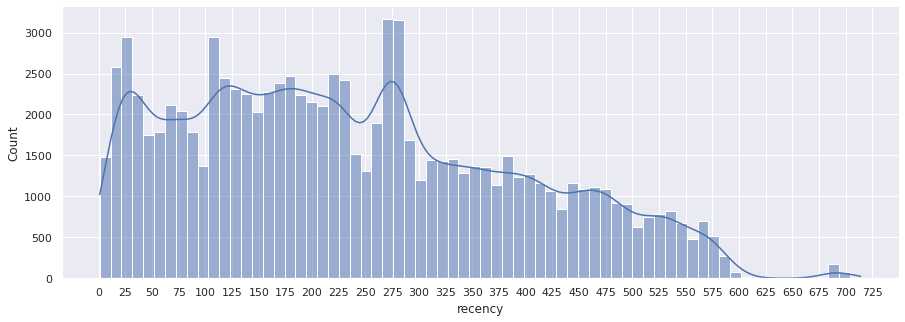

In [59]:
# Распределение Recency - по оси Х - количество дней, по оси Y - количество покупателей с таким числом дней
sns.set(rc={'figure.figsize':(15, 5)})
ax = sns.histplot(rfm.recency, kde=True)
ax.set_xticks(range(0, 750, 25))
sns.despine()

Разобъем Recency на три периода.

Анализируя график, выделяется разделение в 300+ дней, поэтому данные Recency по квантилю 0.66 не будем использовать.
Границу в 147 дней для разделения 33% пользователей округлим до 150 и возьмем за вторую границу.

Итоговые периоды 0 - 150 дней, 150 - 300 дней, 300+ дней.

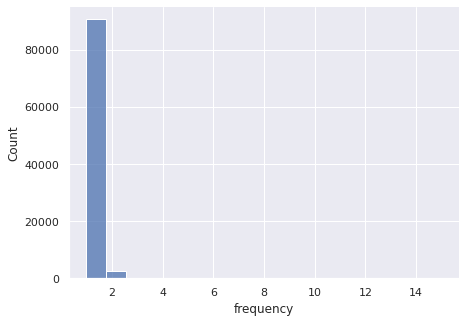

In [60]:
# Распределение Frequency. По оси Х - количество покупок пользователей, по оси Y - количество таких пользователей
sns.set(rc={"figure.figsize": (7, 5)})
ax = sns.histplot(rfm.frequency)
sns.despine()

In [61]:
rfm.frequency.value_counts(normalize=True)*100 

1     96.999722
2      2.756057
3      0.193877
4      0.029992
5      0.009640
6      0.005356
7      0.003213
15     0.001071
9      0.001071
Name: frequency, dtype: float64

Почти 97% клиетов совершили только 1 покупку, поэтому будем делить на сегменты - 1 покупка, 2 покупки, 3 и более покупок.

In [62]:
rfm.monetary.describe() 

count    93358.000000
mean       141.621480
std        215.694014
min          0.850000
25%         47.650000
50%         89.730000
75%        154.737500
max      13440.000000
Name: monetary, dtype: float64

In [63]:
# 90-ый и 99-ый квантили
rfm.monetary.quantile([.9, .99])

0.90     279.99
0.99    1004.99
Name: monetary, dtype: float64

Анализ распределния данных показал, что 90% клиентов тратят менее 280 у.е. и всего 1% - больше 1000. Можно разделить покупателей по медиане (89.73), округлим значнение в большую сторону и возьмём первый диапазон от 0 до 100. Второй диапазон для 90 % пользователей включает значения от 100 до 300. Третий интервал - покупатели, которые совершают дорогие покупки - более 300 у.е.

Таким образом делим данные на сегменты:

**Recency**
- 1 - давние клиенты (более 10 месяцев отсутствия, или более 300 дней)
- 2 - спящие (от 5 до 9 месяцев, или от 150 до 300 дней)
- 3 - недавние (до 5 месяцев, или до 150 дней)

**Frequency**
- 1 - покупает редко (1 покупка)
- 2 - нечасто (2 покупки)
- 3 - часто (3 и более покупок)

**Monetary** 
- 1 - малая сумма чека (покупки до 100 у.е.)
- 2 - средняя сумма чека (покупки от 100 до 300 у.е.)
- 3 - большая сумма чека (покупки от 300 у.е.)

In [64]:
# Теперь запишем ранги сегментов в датафрейм
# Определяем максимальные значения границ метрик
rfm.recency.max(), rfm.frequency.max(), rfm.monetary.max()

(714, 15, 13440.0)

In [65]:
# Добавляем столбцы с номером сегмента
rfm['r'] = pd.cut(rfm.recency, [0, 150, 300, 715], labels = ['3', '2', '1']).astype(str)
rfm['f'] = pd.cut(rfm.frequency, [0, 1, 2, 16], labels = ['1', '2', '3']).astype(str)
rfm['m'] = pd.cut(rfm.monetary, [0, 100, 300, 13441], labels = ['1', '2', '3']).astype(str)

Создаем столбец rfm_score. При трех метриках и 3-бальной ранговой системе, вариантов комбинаций будет 27.

In [66]:
rfm['rfm_score'] = rfm.r + rfm.f + rfm.m
rfm.head()

,customer_unique_id,recency,frequency,monetary,r,f,m,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,2,312
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,2,212


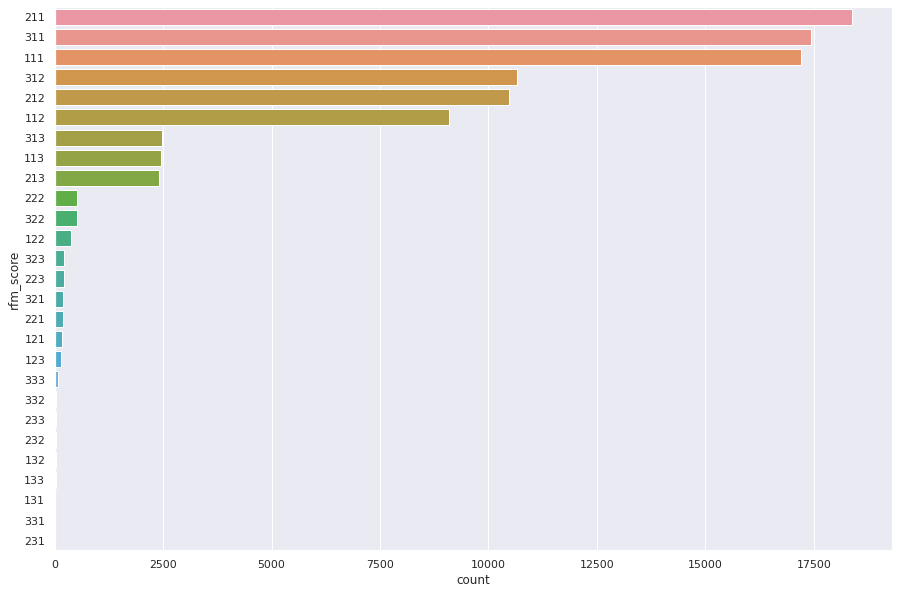

In [67]:
sns.set(rc={"figure.figsize": (15, 10)})
ax = sns.countplot(y=rfm.rfm_score, order=rfm.rfm_score.value_counts().index)

 Визуализация показала нам ТОП-5 покупателей:
 - 211 - спящие: пользователи, покупающие редко и мало;
 - 311 - многообещающие: недавние пользователи, которые купили что-то недорогое один раз;
 - 111 - бездействующие: купили что-то недорогое один раз и не вернулись;
 - 312 - нуждаются во внимании: покупали недавно, мало заказов, средняя выручка;
 - 212 - нуждаются во внимании: покупали недавно, мало заказов, средняя выручка